In [35]:
import os

import pandas as pd
import numpy as np
import gensim
import nltk
import re
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from nltk import tokenize
from IPython.display import Image
%matplotlib inline

# From business task to formalized ML task

## Step One - Determine Business Understanding

High level explanation of the problem:

```
Summary writing is a crucial skill for learners, enhancing reading comprehension and promoting critical thinking. However, evaluating student summaries is time-consuming for teachers. Although there are automated evaluation techniques, they don't cater well to summary writing due to its inherent complexities. 

The aim is to develop a model that can effectively evaluate student summaries, assisting teachers and providing immediate feedback to students.
```

Detailed explanation: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview.

## Step Two - Data Understanding

**Dataset Description**

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording.

**_What am I predicting?_**

The goal of the competition is to predict content and wording scores for summaries on unseen topics.

**_Files and Field Information_**

- summaries_train.csv - Summaries in the training set.
    - student_id - The ID of the student writer.
    - prompt_id - The ID of the prompt which links to the prompt file.
    - text - The full text of the student's summary.
    - content - The content score for the summary. The first target.
    - wording - The wording score for the summary. The second target.
- summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.
- prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
    - prompt_id - The ID of the prompt which links to the summaries file.
    - prompt_question - The specific question the students are asked to respond to.
    - prompt_title - A short-hand title for the prompt.
    - prompt_text - The full prompt text.
- prompts_test.csv - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.
- sample_submission.csv - A submission file in the correct format.

The given datasets have no missing values.

The full test set comprises about 17,000 summaries from a large number of prompts.

Detailed explanation: https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/data.

In [36]:
os.listdir("../data/commonlit-evaluate-student-summaries/")

['commonlit-evaluate-student-summaries.zip',
 'prompts_test.csv',
 'prompts_train.csv',
 'sample_submission.csv',
 'summaries_test.csv',
 'summaries_train.csv']

In [37]:
prompts_train = pd.read_csv("../data/commonlit-evaluate-student-summaries/prompts_train.csv")
prompts_test = pd.read_csv("../data/commonlit-evaluate-student-summaries/prompts_test.csv")
summaries_train = pd.read_csv("../data/commonlit-evaluate-student-summaries/summaries_train.csv")
summaries_test = pd.read_csv("../data/commonlit-evaluate-student-summaries/summaries_test.csv")
sample_submission = pd.read_csv("../data/commonlit-evaluate-student-summaries/sample_submission.csv")

### Training data

In [38]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [39]:
prompts_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        4 non-null      object
 1   prompt_question  4 non-null      object
 2   prompt_title     4 non-null      object
 3   prompt_text      4 non-null      object
dtypes: object(4)
memory usage: 256.0+ bytes


In [40]:
summaries_train

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
...,...,...,...,...,...
7160,ff7c7e70df07,ebad26,They used all sorts of chemical concoctions to...,0.205683,0.380538
7161,ffc34d056498,3b9047,The lowest classes are slaves and farmers slav...,-0.308448,0.048171
7162,ffd1576d2e1b,3b9047,they sorta made people start workin...,-1.408180,-0.493603
7163,ffe4a98093b2,39c16e,An ideal tragety has three elements that make ...,-0.393310,0.627128


In [41]:
summaries_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


### Test data

In [42]:
prompts_test

,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


In [43]:
prompts_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   prompt_id        2 non-null      object
 1   prompt_question  2 non-null      object
 2   prompt_title     2 non-null      object
 3   prompt_text      2 non-null      object
dtypes: object(4)
memory usage: 192.0+ bytes


In [44]:
summaries_test

,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [45]:
summaries_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  4 non-null      object
 1   prompt_id   4 non-null      object
 2   text        4 non-null      object
dtypes: object(3)
memory usage: 224.0+ bytes


In [46]:
sample_submission.head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [47]:
summaries_train.content.value_counts()

-1.547163    426
 0.205683    380
-0.093814    286
-1.264214    173
 0.297031    171
            ... 
 1.388088      1
 1.249104      1
 1.970533      1
 2.160927      1
 1.520355      1
Name: content, Length: 1134, dtype: int64

In [48]:
summaries_train.wording.value_counts()

-1.461245    426
 0.380538    380
 0.503833    286
-1.505073    173
-0.168734    171
            ... 
 1.207819      1
 0.240178      1
 1.040696      1
 1.420841      1
-0.292990      1
Name: wording, Length: 1134, dtype: int64

## Preparation for step 5


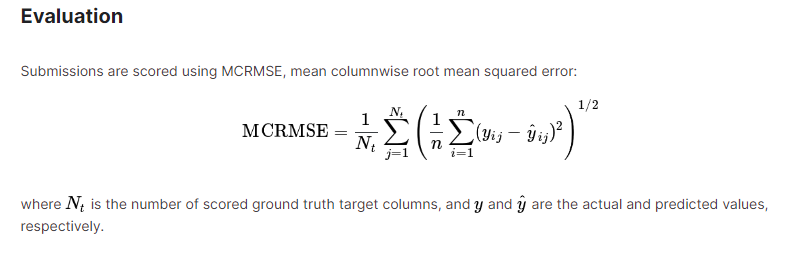

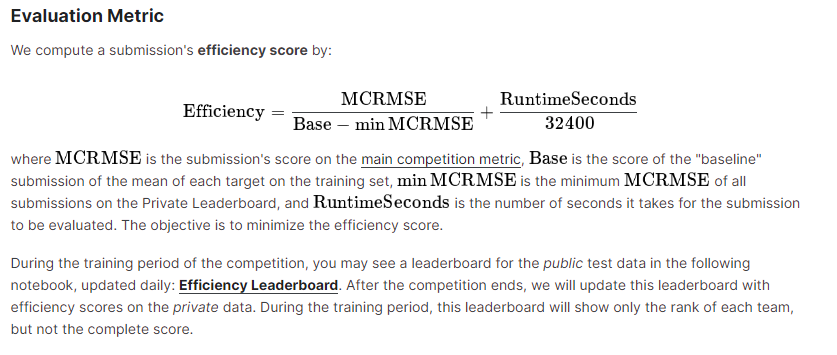

Details: www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview/evaluation

## Step Three - Data Preparation

In [49]:
profile_prompts = ProfileReport(prompts_train, title="Profiling Report: prompts")
profile_prompts

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [50]:
profile_summaries = ProfileReport(summaries_train, title="Profiling Report: summaries")
profile_summaries

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [51]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess_hard(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and 
            # len(token) > 2 and 
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\olhab\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

# Check how it will influence different ML models
def process_light(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\olhab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
summaries_train["is_train"] = True
summaries_test["is_train"] = False

train_test = pd.concat([summaries_train, summaries_test]).reset_index(drop=True)

In [54]:
train_test["hard_clean_text"] = train_test['text'].apply(preprocess_hard)
train_test["light_clean_text"] = train_test['text'].apply(process_light)

In [55]:
idx = 5

print(
    f"Before : {train_test['text'].iloc[idx]}\n"
    f"Hard Processing : {train_test['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {train_test['light_clean_text'].iloc[idx]}\n"
)

idx = 50

print(
    f"Before : {train_test['text'].iloc[idx]}\n"
    f"Hard Processing : {train_test['hard_clean_text'].iloc[idx]}\n"
    f"Light Processing : {train_test['light_clean_text'].iloc[idx]}\n"
)

Before : They would use chemicals and substances to change the color or hide the foul odors to cover up spoiled meat. They would also shred up spoiled and normal meat together into sausage and use many different substances to mask the signs of spoiling.
Hard Processing : use chemicals substances change color hide foul odors cover spoiled meat shred spoiled normal meat sausage use different substances mask signs spoiling
Light Processing : They would use chemicals and substances to change the color or hide the foul odors to cover up spoiled meat. They would also shred up spoiled and normal meat together into sausage and use many different substances to mask the signs of spoiling.

Before : One element of an ideal tragedy is having a complex plan, not simple. It should show pity and fear. Another characteristic is a well-constructed plot, there should be one problem, rather than multiple. Lastly,  the kind of tragedy that takes place,  and the twist ending. 
Hard Processing : element ide

In [ ]:
plt.figure(figsize = (20,20)) 
plt.title("Original Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Hard Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['hard_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Light Processing Text")
wc = WordCloud(max_words = 500 , width = 800 , height = 400).generate(" ".join(train_test['light_clean_text']))
plt.imshow(wc, interpolation = 'bilinear')
plt.show()

In [ ]:
# Dear lecturers! Unfortunately, I wasn't able to finish the task on time due to the fact that it took too long for Kaggle's support team to allow me to pass the verification procedure. Though it won't affect the score for my homework, I'll finish it for myself and try to avoid the similar situations in the future. Thank you for your understanding!